In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from lightgbm import LGBMClassifier 
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.plotting import plot_decision_regions

In [145]:
df = pd.read_csv("F:/dataset_for_ML/Ensemble Learning/classification/adultIncomePrediction.csv")

In [146]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [147]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [148]:
df.duplicated().sum()

24

In [149]:
df.drop_duplicates(inplace=True)

In [150]:
df.columns,df.shape

(Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
        'marital.status', 'occupation', 'relationship', 'race', 'sex',
        'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
        'income'],
       dtype='object'),
 (32537, 15))

In [151]:
df.sample(10)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
5332,37,Private,387430,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,37,United-States,<=50K
24489,44,Private,157236,Some-college,10,Married-spouse-absent,Handlers-cleaners,Unmarried,White,Male,0,0,40,Poland,<=50K
25838,50,Private,23686,Some-college,10,Married-civ-spouse,Adm-clerical,Other-relative,White,Female,0,0,35,United-States,>50K
12935,49,Self-emp-inc,213354,Masters,14,Separated,Exec-managerial,Not-in-family,White,Male,0,0,70,United-States,>50K
27062,21,Private,118401,Some-college,10,Never-married,Other-service,Not-in-family,White,Female,0,0,30,United-States,<=50K
9509,29,Private,187327,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,40,United-States,<=50K
4504,62,Private,159841,HS-grad,9,Widowed,Other-service,Not-in-family,White,Female,0,0,24,United-States,<=50K
12286,29,Private,147340,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,40,United-States,<=50K
12842,29,Private,29732,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,24,United-States,<=50K
10049,36,Private,96452,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,45,United-States,<=50K


1) for workclass, those workclass below 1000, replace with the value others 
2) For education, we already have a label feature named education.num 
3) same for marital.status as workclass, for below valuecounts of 1000, we will replace it with others 
4) same as number 3 and number 1. for occupation
5) for native county, we will do the same as number 1,3 and 4. i.e. use one-hot-encoding and classify it as others.
6) We have question mark data on two columns, workforce and occupation !  

In [152]:

# df["marital.status"].value_counts()
# df["occupation"].value_counts()
# df["relationship"].value_counts()
# df["capital.gain"].value_counts()
# df["native.country"].value_counts()
# df["income"].value_counts()
# df["hours.per.week"].value_counts().values

<!-- here, the income is divided into lessthan or equals to 50, and greater than 50, we will just use 0 and 1 , as like in normal classification!  -->

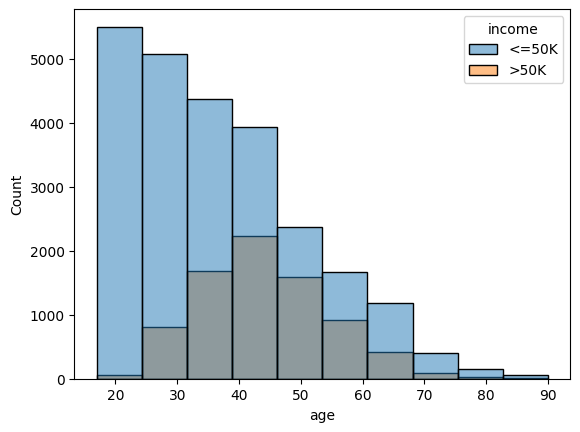

In [153]:
sns.histplot(x=df['age'],hue=df["income"],bins=10)
plt.show()

<Axes: xlabel='fnlwgt', ylabel='age'>

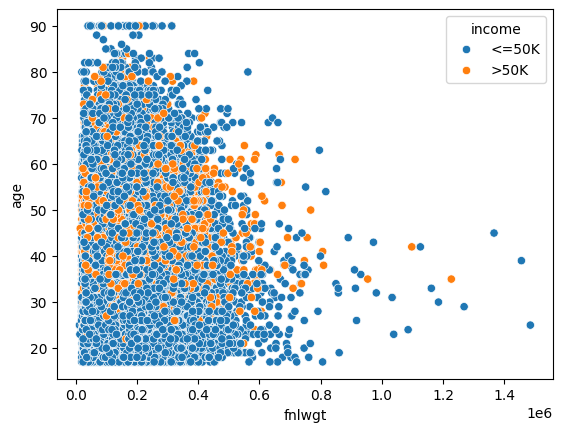

In [154]:
sns.scatterplot(x=df["fnlwgt"],y=df["age"],hue=df["income"])

In [155]:
df["fnlwgt"].describe(include="all")

count    3.253700e+04
mean     1.897808e+05
std      1.055565e+05
min      1.228500e+04
25%      1.178270e+05
50%      1.783560e+05
75%      2.369930e+05
max      1.484705e+06
Name: fnlwgt, dtype: float64

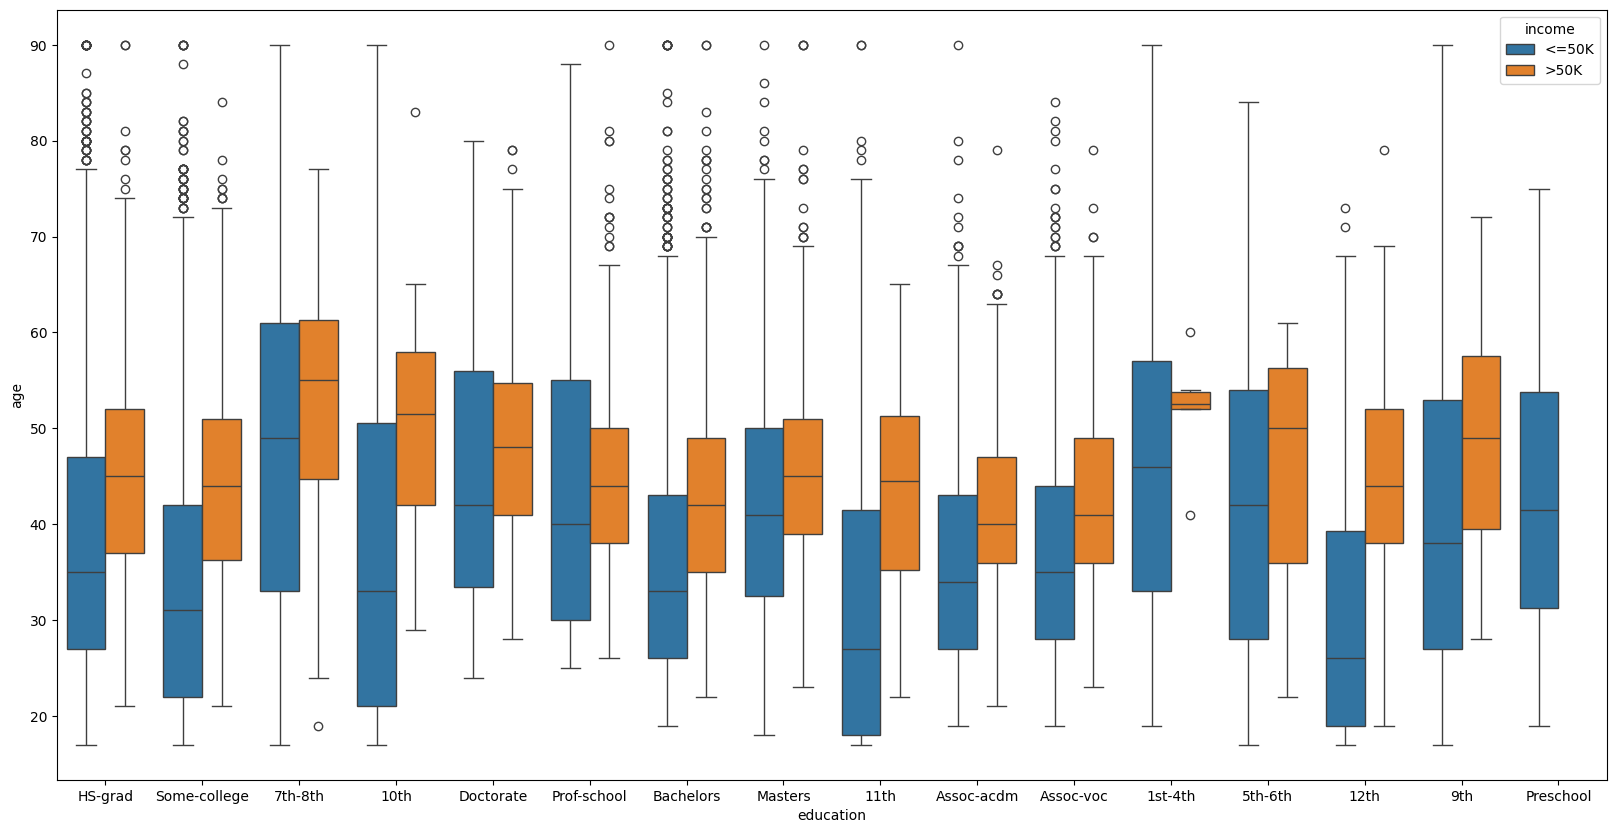

In [156]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df,y="age",x="education",hue="income")
plt.show()

In [157]:
df['marital.status'].value_counts().values

array([14970, 10667,  4441,  1025,   993,   418,    23], dtype=int64)

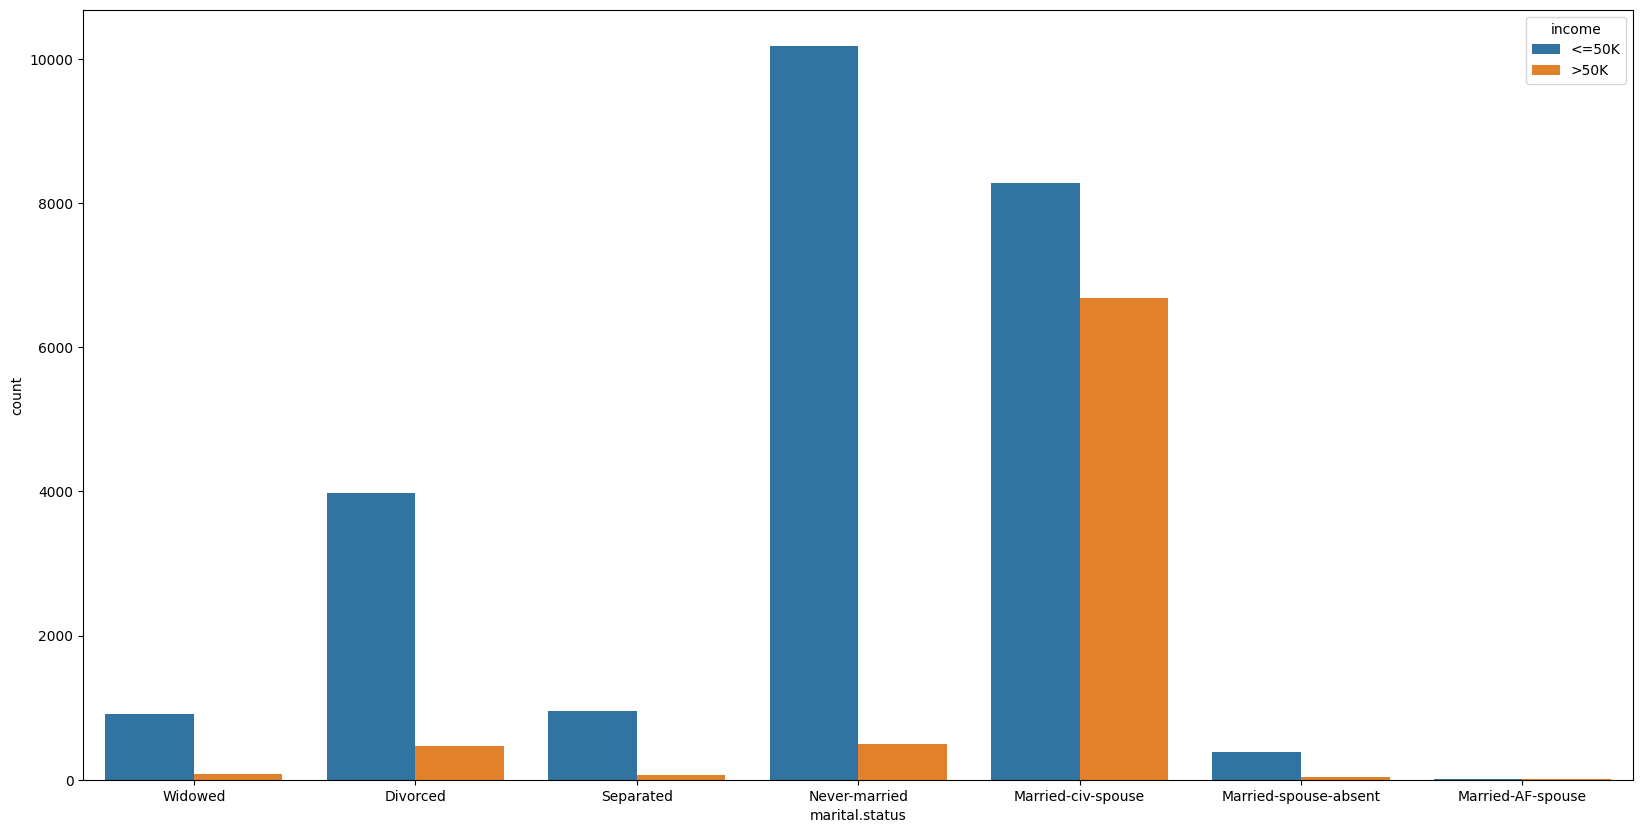

In [158]:
plt.figure(figsize=(20,10))
sns.countplot(data=df,x='marital.status',hue="income")
plt.show()

<Axes: xlabel='age', ylabel='Count'>

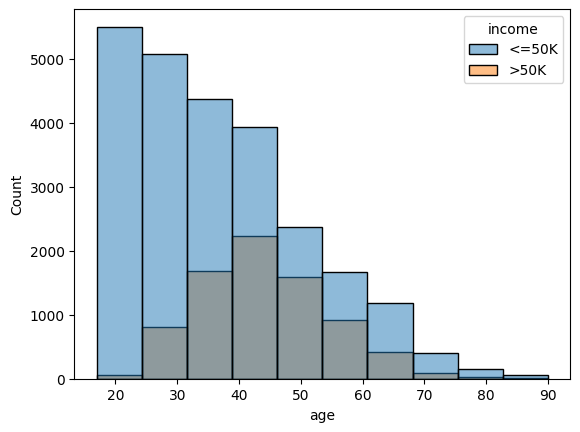

In [159]:
sns.histplot(data=df,x="age",bins=10,hue="income")

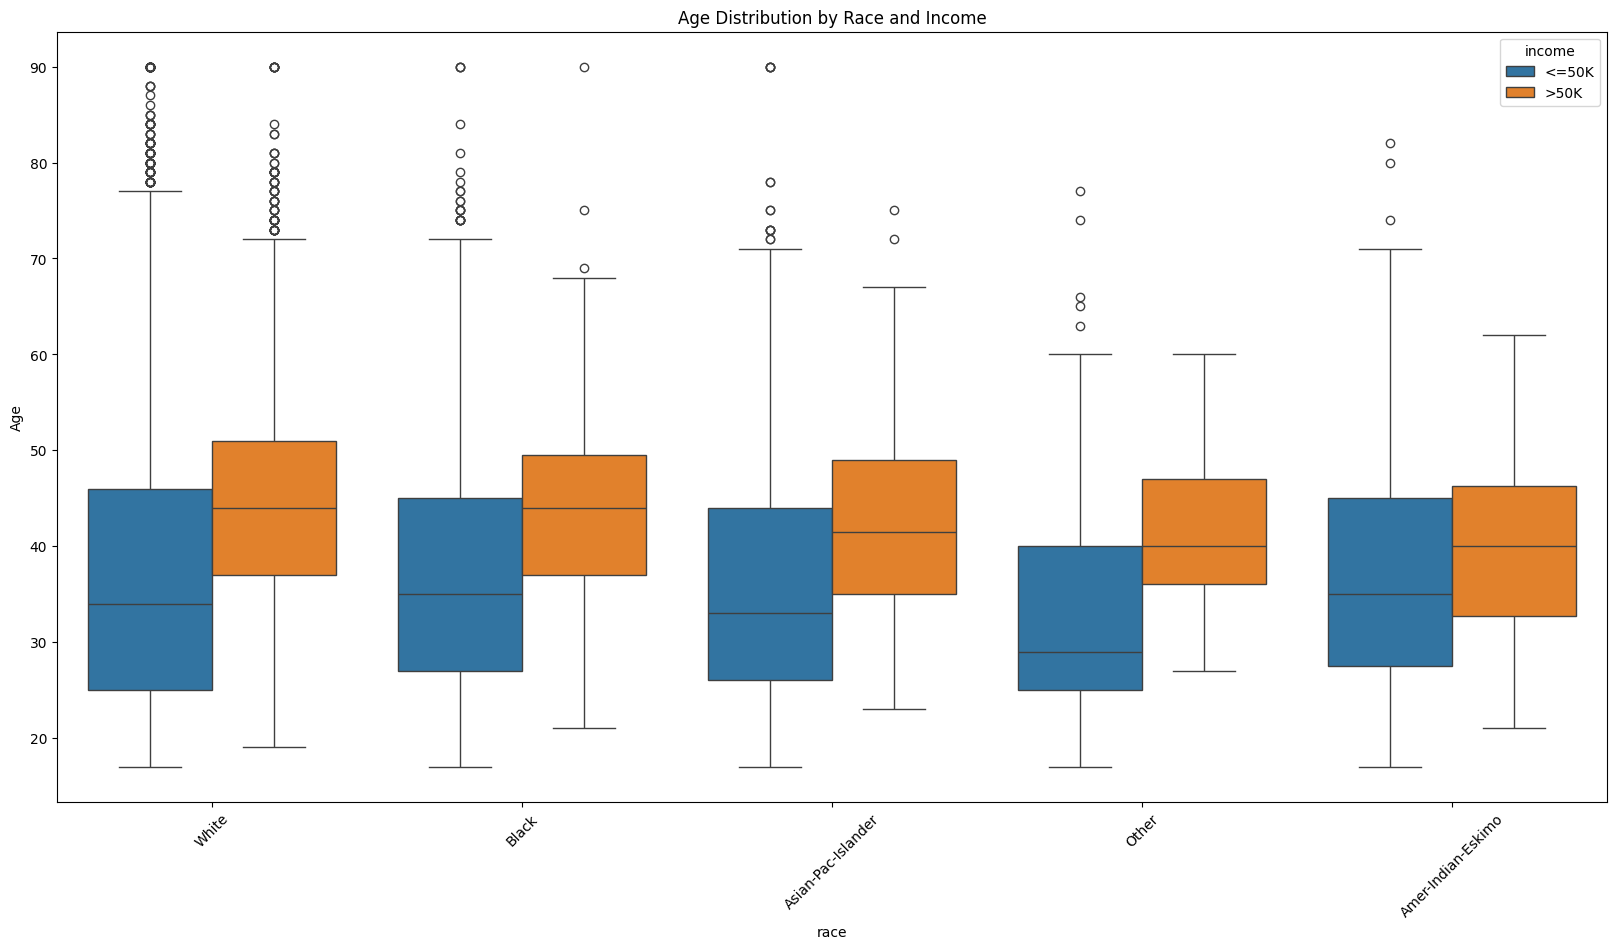

In [160]:
plt.figure(figsize=(20,10))
sns.boxplot(x='race', y='age', hue='income', data=df)
plt.xticks(rotation=45)
plt.title("Age Distribution by Race and Income")
plt.ylabel("Age")
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_20976\928673097.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\DELL\AppData\Local\Temp\ipykernel_20976\928673097.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


<Figure size 2000x1000 with 0 Axes>

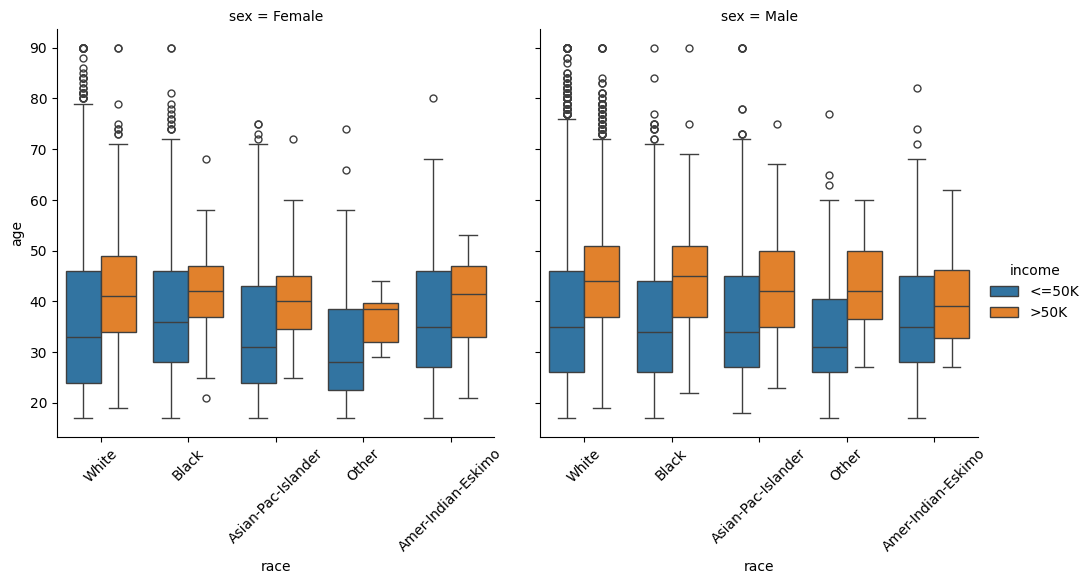

In [161]:
plt.figure(figsize=(20,10))
g = sns.catplot(
    data=df,
    x="race",
    y="age",
    kind="box",  
    hue="income",  
    # row="sex",    
    col="sex",    
)
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

In [162]:
df["age"].describe()

count    32537.000000
mean        38.585549
std         13.637984
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64

In [163]:
X = df.iloc[:,:-1]
y = df["income"]

In [164]:
X

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States


In [165]:
df["native.country"].value_counts()

native.country
United-States                 29153
Mexico                          639
?                               582
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        62
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
Greece       

In [166]:
imputer = SimpleImputer(missing_values="?",strategy="most_frequent")

In [167]:
X[["workclass","occupation","native.country"]]= imputer.fit_transform(X[["workclass","occupation","native.country"]])

In [168]:
X

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,90,Private,77053,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States
2,66,Private,186061,Some-college,10,Widowed,Prof-specialty,Unmarried,Black,Female,0,4356,40,United-States
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States


In [169]:
# workforce, marital.status,occupation,native.country 

In [170]:
def downsizingTheCatCols(temp_df,columns,threshold=1000):
    for col in columns:
        # print(col)
        # print(temp_df[col])
        if col == "native.country":
            # print("Column name",col)
            threshold=100
            # print(threshold)

        value_counts=temp_df[col].value_counts()
        # print(threshold)
        rare_categories = value_counts[value_counts<threshold].index
        # print(rare_categories)
        temp_df[col] = temp_df[col].apply(lambda x: 'Other' if x in rare_categories else x)

    return temp_df
        

        

In [171]:
X = downsizingTheCatCols(X,["workclass","marital.status","occupation","native.country"])

In [172]:
# X["workclass"].value_counts()
# X["native.country"].value_counts()
# X["occupation"].value_counts()
# X["workclass"].value_counts()
# X["workclass"].value_counts()

##### here, in occupation, others and other-services will be treated differently

## NOW, we will use encoder and feature scaling for dataset, 

In [173]:
X.drop(columns="education",inplace=True)

In [174]:
X["education.num"].value_counts()

education.num
9     10494
10     7282
13     5353
14     1722
11     1382
7      1175
12     1067
6       933
4       645
15      576
5       514
8       433
16      413
3       332
2       166
1        50
Name: count, dtype: int64

In [175]:
X.columns

Index(['age', 'workclass', 'fnlwgt', 'education.num', 'marital.status',
       'occupation', 'relationship', 'race', 'sex', 'capital.gain',
       'capital.loss', 'hours.per.week', 'native.country'],
      dtype='object')

In [191]:
num_cols = ["age","fnlwgt","capital.gain","capital.loss","hours.per.week"]
one_hot_cols = ["workclass","marital.status","occupation","relationship","sex","race","native.country"]

In [192]:
standard_scaling_ppl = Pipeline(
    steps=[
        ("standardScalingInNumericalcols",StandardScaler())
    ]
)
one_hot_encoding_ppl = Pipeline(
    steps=[
        ("OneHotEncodingForCatCols",OneHotEncoder(drop="first",sparse_output=True,handle_unknown="ignore"))
    ]
)

In [193]:
preprocessing = ColumnTransformer(
    transformers=[
        ("SS",standard_scaling_ppl,num_cols),
        ("ohe",one_hot_encoding_ppl,one_hot_cols)
    ],
    remainder="passthrough",
    n_jobs=-1
)

In [194]:
preprocessing

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('SS',
                                 Pipeline(steps=[('standardScalingInNumericalcols',
                                                  StandardScaler())]),
                                 ['age', 'fnlwgt', 'capital.gain',
                                  'capital.loss', 'hours.per.week']),
                                ('ohe',
                                 Pipeline(steps=[('OneHotEncodingForCatCols',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['workclass', 'marital.status', 'occupation',
                                  'relationship', 'sex', 'race',
                                  'native.country'])])